# 读取数据

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def load_data():
    # 读取第一个CSV文件
    df = pd.read_csv('global_lasso_data.csv')
    # df = pd.read_csv('bond_230009_2304_2403.csv')
    # header_string = "dl_cd,txn_dt,stlmnt_dt,dl_tm,bsns_tm,bond_cd,bnds_nm,net_prc,yld_to_mrty,nmnl_vol,amnt,acrd_intrst,totl_acrd_intrst,all_prc,stlmnt_amnt,ttm_yrly,byr_qt_cd,byr_instn_cd,byr_cfets_instn_cd,byr_instn_cn_full_nm,byr_instn_cn_shrt_nm,byr_instn_en_shrt_nm,byr_trdr_nm,byr_adrs,byr_trdr_fax,byr_lgl_rprsntv,byr_trdr_tel,buy_side_trdng_acnt_cd,byr_cptl_bnk_nm,byr_cptl_acnt_no,byr_pymnt_sys_cd,byr_dpst_acnt_nm,buy_side_dpst_cd,byr_trd_acnt_cfets_cd,byr_trd_acnt_cn_full_nm,byr_trd_acnt_cn_shrt_nm,byr_trd_acnt_en_shrt_nm,byr_cptl_acnt_nm,byr_trd_acnt_en_full_nm,slr_qt_cd,slr_instn_cd,slr_cfets_instn_cd,slr_instn_cn_full_nm,slr_instn_cn_shrt_nm,slr_instn_en_shrt_nm,slr_trdr_cd,slr_trdr_nm,slr_adrs,slr_trdr_fax,slr_lgl_rprsntv,slr_trdr_tel,sell_side_trdng_acnt_cd,slr_cptl_bnk_nm,slr_cptl_acnt_no,slr_pymnt_sys_cd,slr_dpst_acnt_nm,sell_side_dpst_acnt,slr_trd_acnt_cfets_cd,slr_trd_acnt_cn_full_nm,slr_trd_acnt_cn_shrt_nm,slr_trd_acnt_en_shrt_nm,slr_cptl_acnt_nm,slr_trd_acnt_en_full_nm,crt_tm,upd_tm"
    # # 使用split()方法将字符串转换为列表
    # header_list = header_string.split(',')
    return df

df = load_data()

# Feature Engineering and clustering

用于第一阶段的数据预处理，构建特征

In [2]:
def fliter_by_user(df,instn_cd):
    # 对于指定user在买入位(byr_instn_cd)和卖出位(slr_instn_cd)的交易进行筛选
    filtered_df = df[(df['byr_instn_cd'] == instn_cd) | (df['slr_instn_cd'] == instn_cd)]
    return filtered_df

def standardize_feature_matrix(feature_matrix):
    standard_scaler = StandardScaler()
    df_standard_scaled = feature_matrix.copy()  # 复制DataFrame以避免更改原始数据
    print(df_standard_scaled.columns.tolist())
    df_standard_scaled[df_standard_scaled.columns.tolist()[1:]] = standard_scaler.fit_transform(df_standard_scaled[df_standard_scaled.columns.tolist()[1:]])
    return df_standard_scaled

def construct_base_feature(df):
    # 1. 计算交易频率
    df['dl_tm'] = pd.to_datetime(df['dl_tm'])  # 将dl_tm转换为日期时间类型
    df['date'] = df['dl_tm'].dt.date  # 提取日期
    df['week'] = df['dl_tm'].dt.week  # 提取周
    df['month'] = df['dl_tm'].dt.month  # 提取月份
    df['year'] = df['dl_tm'].dt.year  # 提取月份
    
    # day_feq 计算每个机构的day_feq均值、最大值、最小值、标准差
    daily_freq = df.groupby(['byr_instn_cn_full_nm', 'date']).size().reset_index(name='day_feq')
    daily_freq_stats = daily_freq.groupby('byr_instn_cn_full_nm')['day_feq'].agg(['mean', 'max', 'min', 'std']).reset_index()
    daily_freq_stats['std'].fillna(-daily_freq_stats['std'].mean(), inplace=True)

    # week_feq 计算每个机构的week_feq均值、最大值、最小值、标准差
    weekly_freq = df.groupby(['byr_instn_cn_full_nm', 'week']).size().reset_index(name='week_feq')
    weekly_freq_stats = weekly_freq.groupby('byr_instn_cn_full_nm')['week_feq'].agg(['mean', 'max', 'min', 'std']).reset_index()
    weekly_freq_stats['std'].fillna(-weekly_freq_stats['std'].mean(), inplace=True)

    # month_feq 计算每个机构的month_feq均值、最大值、最小值、标准差
    monthly_freq = df.groupby(['byr_instn_cn_full_nm', 'month']).size().reset_index(name='month_feq')
    monthly_freq_stats = monthly_freq.groupby('byr_instn_cn_full_nm')['month_feq'].agg(['mean', 'max', 'min', 'std']).reset_index()
    monthly_freq_stats['std'].fillna(-monthly_freq_stats['std'].mean(), inplace=True)

    # year_feq 计算每个机构的year_feq均值、最大值、最小值、标准差
    yearly_freq = df.groupby(['byr_instn_cn_full_nm', 'year']).size().reset_index(name='year_feq')
    yearly_freq_stats = yearly_freq.groupby('byr_instn_cn_full_nm')['year_feq'].agg(['mean', 'max', 'min']).reset_index()

    # 2. 计算每个机构的平均交易金额、最大交易金额、最小交易金额以及交易金额的标准差
    transaction_amount = df.groupby('byr_instn_cn_full_nm')['nmnl_vol'].sum().reset_index(name='all_nmnl_vol')
    transaction_amount_stats = df.groupby('byr_instn_cn_full_nm')['nmnl_vol'].agg(['mean', 'max', 'min', 'std']).reset_index()
    transaction_amount_stats['std'].fillna(-transaction_amount_stats['std'].mean(), inplace=True)

    # 3. 构建特征矩阵
    feature_matrix = daily_freq_stats.merge(weekly_freq_stats, on='byr_instn_cn_full_nm', suffixes=('_daily', '_weekly'))
    feature_matrix = feature_matrix.merge(monthly_freq_stats, on='byr_instn_cn_full_nm', suffixes=('_weekly','_monthly'))
    feature_matrix = feature_matrix.merge(yearly_freq_stats, on='byr_instn_cn_full_nm', suffixes=('_monthly','_yearly'))
    feature_matrix = feature_matrix.merge(transaction_amount, on='byr_instn_cn_full_nm')
    feature_matrix = feature_matrix.merge(transaction_amount_stats, on='byr_instn_cn_full_nm', suffixes=('_yearly','_amount'))
    return feature_matrix

def construct_feature_by_volume(df):
    # 基于交易量的四分位数来划分区间
    # 针对每一个组别进行分析以理解不同交易量的市场行为
    return df

def construct_feature_by_price(df):
    # 基于交易价的四分位数来划分区间，他们的频数可以反映交易行为偏好
    return df

def concat_feature_matrix(df_list):
    for df in df_list:
      feature_matrix = pd.concat([feature_matrix, df], axis=1)
    return feature_matrix

def construct_feature(df):
    # 1. 每个机构的day_feq、week_feq和month_feq
    # 2. 平均交易金额、最大交易金额、最小交易金额以及交易金额的波动程度
    # 3. 总的交易金额除以交易频率可以得到每笔交易的平均金额，这反映了机构的交易规模
    # 4. 各机构可能有其偏好的交易时间
    # 5. 机构可能有其偏好的交易方向，可以统计每个机构买入和卖出的次数，以及买入和卖出的金额
    volume_feature = construct_feature_by_volume(df)
    price_feature = construct_feature_by_price(df)
    base_feature_matrix = construct_base_feature(df)
    feature_matrix = concat_feature_matrix(volume_feature, price_feature, base_feature_matrix)
    return feature_matrix

def cluster():
    # 基于交易对手方的特征进行聚类，从而划分成几个交易对手方的cluster
    # 特征主要是交易数据产生的对手方偏好，交易历史信息生成。可以再加上一个基础的用户画像特征构造。
    return df

# Visualization
使用构建的特征对每个机构进行聚类和降维
可以简单的将长线资本等机构分离出来

In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 设置中文字体为黑体

def apply_MDS(data, n_components=2):
    data = data.drop(columns=['byr_instn_cn_full_nm'])
    mds = MDS(n_components=n_components)
    mds_projection = mds.fit_transform(data)
    return mds_projection

def apply_PCA(data, n_components=2):
    data = data.drop(columns=['byr_instn_cn_full_nm'])
    pca = PCA(n_components=n_components)
    pca_projection = pca.fit_transform(data)
    return pca_projection

def apply_clustering(pca_projection, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(pca_projection)
    return clusters

feature_matrix = construct_base_feature(df)
standard_feature_matrix = standardize_feature_matrix(feature_matrix)

# 示例用法
# 假设data是您的数据，格式为DataFrame
pca_projection = apply_MDS(standard_feature_matrix)
clusters = apply_clustering(pca_projection, n_clusters=3)
# 可视化PCA结果
plt.scatter(pca_projection[:, 0], pca_projection[:, 1], c=clusters, cmap='viridis', alpha=0.5)

# 在每个点上标注ID
for i, txt in enumerate(standard_feature_matrix['byr_instn_cn_full_nm']):
    # 调整标签位置，向右上方移动一定距离
    x_offset = 0.1
    y_offset = 0.1
    plt.text(pca_projection[i, 0] + x_offset, pca_projection[i, 1] + y_offset, txt, fontsize=8, rotation=45)

plt.title('PCA Projection')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

KeyError: 'dl_tm'

# Transactions events split

In [ ]:
def merge_transactions(df, window=3):
    # 将日期转换为 datetime 对象
    df['date'] = pd.to_datetime(df['date'])

    # 根据日期和其他关键列对数据进行排序
    df = df.sort_values(by=['date', 'buyer', 'seller'])
    merged_transactions = []
    current_transaction = None
    
    for _, row in df.iterrows():
        if current_transaction is None:
            current_transaction = row
            continue
        
        if (row['date'] - current_transaction['date']).days <= window:
            if row['buyer'] == current_transaction['buyer'] and row['seller'] == current_transaction['seller'] and row['price'] == current_transaction['price']:
                current_transaction['volume'] += row['volume']
            else:
                merged_transactions.append(current_transaction)
                current_transaction = row
        else:
            merged_transactions.append(current_transaction)
            current_transaction = row
            
    if current_transaction is not None:
        merged_transactions.append(current_transaction)
    
    return pd.DataFrame(merged_transactions)

def preprocess_data(df):
    # 设置 Pandas 显示选项
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)

    # 将交易时间列转换为 datetime 对象
    df['dl_tm'] = pd.to_datetime(df['dl_tm'])

    # 将字符串列转换为字符串类型
    df['byr_instn_cn_full_nm'] = df['byr_instn_cn_full_nm'].astype(str)
    df['slr_instn_cn_full_nm'] = df['slr_instn_cn_full_nm'].astype(str)
    df['byr_trdr_nm'] = df['byr_trdr_nm'].astype(str)
    df['slr_trdr_nm'] = df['slr_trdr_nm'].astype(str)

    # 将购买和销售机构合并为一个列
    df['instn'] = df['byr_instn_cn_full_nm'].str.cat(df['slr_instn_cn_full_nm'], sep=',')

    # 计算每个月每个机构的交易次数
    df['byr_instn_cn_full_nm'] = df['byr_instn_cn_full_nm'].str[:6].str.cat(df['byr_trdr_nm'], sep='')
    df['slr_instn_cn_full_nm'] = df['slr_instn_cn_full_nm'].str[:6].str.cat(df['slr_trdr_nm'], sep='')
    df['byr_trdr_nm'] = df['byr_trdr_nm'].str.ljust(4)
    df['slr_trdr_nm'] = df['slr_trdr_nm'].str.ljust(4)
    df['nmnl_vol'] = np.int64(df["nmnl_vol"]/10000000)
    df['net_prc'] = (df["net_prc"]).round(2)

    # 提取需要的列
    result = df[['dl_tm', 'stlmnt_dt', 'slr_instn_cn_full_nm', 'byr_instn_cn_full_nm', 'nmnl_vol', 'net_prc']]

    # 重命名列以使其更易读
    result = result.rename(columns={"dl_tm" :'date_dl', "stlmnt_dt" :'date','byr_instn_cn_full_nm':'buyer','slr_instn_cn_full_nm':"seller",  'instn': 'Institution', 'nmnl_vol': 'volume', 'net_prc': "price"})

    return merge_transactions(result)


In [ ]:
# 读取某只债券的数据
df = load_data()
# 预处理
merged_df = preprocess_data(df)

print(merged_df)

                      date_dl       date      seller       buyer  volume  \
117 2020-06-01 14:28:19+08:00 2020-06-01    中信银行股份张勇   东方证券股份陈玉婷      20   
109 2020-06-01 13:52:37+08:00 2020-06-01    中国光大银行张璇   东方证券股份陈玉婷      10   
113 2020-06-01 14:24:08+08:00 2020-06-01    厦门银行股份赵颖    中国人民财产丁仪      20   
115 2020-06-01 14:40:04+08:00 2020-06-01   山西证券股份赖颂怡    中国人民财产丁仪      10   
108 2020-06-01 14:03:49+08:00 2020-06-01   广东华兴银行潘志煊    中国人民财产丁仪      10   
116 2020-06-01 14:24:08+08:00 2020-06-01    申万宏源证券王丹    厦门银行股份赵颖      20   
111 2020-06-01 14:39:45+08:00 2020-06-01   兴业银行股份陈颖1   山西证券股份赖颂怡      10   
112 2020-06-01 13:38:38+08:00 2020-06-01    上海浦东发展宋震   新华资产管理张颖涵       6   
110 2020-06-01 15:23:16+08:00 2020-06-01   东方证券股份陈玉婷   新华资产管理郝黎红      39   
114 2020-06-01 13:55:45+08:00 2020-06-01   国盛证券有限曾思琨    申万宏源证券王丹      30   
119 2020-09-17 15:05:56+08:00 2020-09-17    天风证券股份曾鑫    华夏人寿保险李腾       9   
120 2020-09-17 14:49:02+08:00 2020-09-17   国海证券股份赵维君    天风证券股份曾鑫       9   
5   2023-03-

# 找出异常机构相关的交易
对应到第一阶段的Lasso操作，圈选出异常机构

In [ ]:
inst_list = ['长线资本基金孙姣', '国金证券股份严佳', '华创证券有限马延威', '潍坊银行股份王梓涵', '鄂尔多斯银行郭宁', '粤开证券股份周荃', '交通银行股份何嘉隆', '华源证券股份钱淑雯']

def transactions_filter(df, inst_list):
    selected_transactions = df.loc[
        (df['buyer'].isin(inst_list)) |
        (df['seller'].isin(inst_list))
    ]
    return selected_transactions

sorted_data = transactions_filter(merged_df, inst_list).sort_values(by='date_dl')

print(sorted_data)

                      date_dl       date     seller      buyer  volume   price
30  2023-07-06 13:30:13+08:00 2023-07-06  交通银行股份何嘉隆   川财证券有限李丹      20  110.44
36  2023-07-07 11:40:09+08:00 2023-07-07  交通银行股份何嘉隆   川财证券有限李丹      20  110.51
54  2023-12-06 16:44:13+08:00 2023-12-07  东海证券股份温妍超   长线资本基金孙姣      10  110.36
63  2023-12-07 13:33:23+08:00 2023-12-07   长线资本基金孙姣  华源证券股份钱淑雯      10  110.51
60  2023-12-07 13:35:23+08:00 2023-12-07  华源证券股份钱淑雯   鄂尔多斯银行郭宁      10  110.53
66  2023-12-11 14:14:56+08:00 2023-12-11  华创证券有限马延威  交通银行股份何嘉隆      10  110.53
62  2023-12-11 14:19:24+08:00 2023-12-11   鄂尔多斯银行郭宁  华创证券有限马延威      10  110.53
65  2023-12-11 14:24:34+08:00 2023-12-12  华源证券股份钱淑雯   长线资本基金孙姣      10  110.54
67  2023-12-11 14:27:12+08:00 2023-12-12  交通银行股份何嘉隆   广东顺德农村夏扬      10  110.53
72  2023-12-12 14:08:34+08:00 2023-12-12  华创证券有限马延威   吉林九台农村刘刊      10  110.86
70  2023-12-12 14:14:11+08:00 2023-12-12   长线资本基金孙姣  华创证券有限马延威      10  110.85
77  2023-12-14 14:48:19+08:00 2023-12-14  粤开证券股份葛天翔 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def load_data(merge_df):
    """
    加载数据并进行排序。
    Args:
        merge_df (DataFrame): 合并后的数据帧。

    Returns:
        DataFrame: 排序后的数据帧。
    """
    sorted_data = merge_df[['date_dl','date', 'buyer', 'seller', 'volume', 'price']].sort_values(by='date_dl')
    return sorted_data

def create_directed_graph(data):
    """
    根据数据创建一个多重有向图。
    Args:
        data (DataFrame): 数据帧，包含交易信息。

    Returns:
        nx.MultiDiGraph: 多重有向图对象。
    """
    G = nx.MultiDiGraph()
    # 添加节点和边
    for _, transaction in data.iterrows():
        buyer = transaction["buyer"]
        seller = transaction["seller"]
        volume = transaction["volume"]
        price = transaction["price"]
        time = transaction["date"]
        time_dl = transaction["date_dl"]
        transaction_id = time_dl
        edge_attributes = {"buyer": buyer, "seller": seller, "volume": volume, "price": price, "time": time, "time_dl": time_dl}
        G.add_edge(seller, buyer, key=transaction_id , **edge_attributes)
    return G

def visualize_graph(G):
    # 可视化有向图
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, arrows=True)
    plt.title('Directed Graph')
    plt.show()

def validate_path(G, path):
    """
    验证路径的可行性
    Args:
        G (nx.MultiDiGraph): 多重有向图对象
        path (list): 要验证的路径，其中每个元素是一个三元组 (source, target, key)

    Returns:
        bool: 如果路径有效，则返回True；否则返回False。
    """
    # 如果路径为空，直接返回False
    if not path:
        return False
    
    prev_key = None
    for edge in path:
        source, target, key = edge
        # 获取边的属性字典
        edge_attrs = G[source][target][key]
        # 如果边的键不是递增的，返回False
        if prev_key is not None and key <= prev_key:
            return False
        prev_key = key
    
    return True

def find_all_paths(G):
    """
    查找图中所有节点对之间的路径。
    Args:
        G (nx.MultiDiGraph): 多重有向图对象。

    Returns:
        dict: 包含所有路径的字典，键为节点对，值为路径列表。
    """
    nodes = list(G.nodes())
    all_paths = {}
    for source_node in nodes:
        for target_node in nodes:
            if source_node == target_node:
                continue
            paths = list(nx.all_simple_edge_paths(G, source=source_node, target=target_node))
            valid_paths = [path for path in paths if validate_path(G, path)]
            all_paths[(source_node, target_node)] = valid_paths

    return all_paths

def validate_paths(G, all_paths):
    # 遍历所有路径
    for node_pair, paths in all_paths.items():
        source, target = node_pair
        # 遍历每个路径
        for path in paths:
            # 检查路径是否为空
            if not path:
                continue
            valid = True
            prev_time = None
            # 遍历路径中的每一条边
            for i in range(len(path) - 1):
                # 获取当前边和下一条边
                edge = (path[i], path[i + 1])
                # 检查边是否存在
                if edge not in G.edges:
                    valid = False
                    break
                # 获取边的属性字典
                edge_attrs = G.edges[edge][0]
                # 检查交易时间是否逐渐增大
                if prev_time is not None and 'time' in edge_attrs and edge_attrs['time'] <= prev_time:
                    valid = False
                    break
                prev_time = edge_attrs.get('time', None)
            # 如果路径无效，则从路径列表中移除
            if not valid:
                all_paths[node_pair].remove(path)

    return all_paths

def create_graph_from_paths(all_paths):
    """
    根据路径创建一个简单的有向图。
    Args:
        all_paths (dict): 包含所有路径的字典。

    Returns:
        nx.MultiDiGraph: 简单有向图对象。
    """
    G = nx.MultiGraph()
    for node_pair, paths in all_paths.items():
        source, target = node_pair
        G.add_node(source)
        G.add_node(target)
        G.add_edge(source, target)
    return G

def print_paths_with_transaction_time(all_paths):
    # 遍历所有路径
    for node_pair, paths in all_paths.items():
        source, target = node_pair
        # 遍历每个路径
        for path in paths:
            # 检查路径是否为空
            if not path:
                continue
            # 输出路径
            print(f"从 {source} 到 {target} 的路径：{path}")

# 创建有向图
G_sorted_data = create_directed_graph(sorted_data)

# 查找所有通路
all_paths = find_all_paths(G_sorted_data)

# 构建交易数据

当尝试生成所有可能的链路时，我们可以遵循以下步骤：
- 对原始数据进行操作，以获得每个节点作为中心的简单路径。
- 使用这些简单路径，尝试将它们组合起来，以得到任意节点到任意节点的路径。
  - 首先，我们提取每个路径的源节点和目标节点。
  - 然后，对于每个节点对应的路径列表：
    - 检查每条路径，找到路径的最后一个节点作为当前起点。
    - 如果存在以当前起点为起点的路径，并且满足时间递增的条件，则将它们组合成新的路径。
通过这种方法，我们可以生成从任意节点到任意节点的所有可能链路。

每条路径都有一些指标，现在我要用指标对路径进行排序，最后输出top10的路径。
我的class中有一些方法可以帮助我实现这个功能，请帮我写出其他的辅助性代码

可以总结如下量化的特点：

- 价格连续性: 在链条中，交易价格呈现出较强的连续性，即后续交易价格通常与前一笔交易价格接近。
  - 价格变化率： 计算相邻交易节点的价格变化率，较大的变化率可能表示潜在的超额收益或异常情况。

- 机构重复出现: 长线资本基金孙姣在链条中出现了两次，这种重复出现可能引发关注。特别是在其第二次出现后，价格发生了变化，这可能暗示着潜在的超额收益。
  - 机构重复次数： 计算链条中每个机构出现的次数。如果某个机构出现次数较多，则可能存在异常情况。

- 价格变化: 在链条中，可以观察到价格在某些节点上发生了变化。这种变化可能是因为市场波动、供需变化或其他因素导致的。
  - 价格差异标准差： 计算链条中交易价格的标准差。较大的标准差可能表示价格波动较大，存在异常情况。

- 累计收益率： 计算链条中所有交易的累计收益率。较高的累计收益率可能表示存在超额收益情况。

基于这些量化特点，你可以在其他链条中筛选出类似的可疑链条，并进一步分析其是否存在异常或潜在的超额收益情况。

In [ ]:
from datetime import timedelta
from collections import defaultdict

class Trade:
    def __init__(self, buyer, seller, volume, price, time, time_dl):
        self.buyer = buyer  # 买方
        self.seller = seller  # 卖方
        self.volume = volume  # 交易量
        self.price = price  # 价格
        self.time = time  # 交易时间
        self.time_dl = time_dl  # 交易时间

class Path:
    def __init__(self, source, target, start_time, end_time, path):
        self.source = source
        self.target = target
        self.start_time = start_time
        self.end_time = end_time
        self.path = path  # 路径属性
        self.length = self.calculate_length()  # 路径长度

        self.profit = self.calculate_profit_rate()  # 路径盈利情况
        self.institution_counts = self.count_institution_repeats()  # 机构重复次数
        self.price_std_dev = self.calculate_price_std_dev()  # 价格标准差
        self.price_changes = self.calculate_price_change_rate()  # 价格变化率

        self.profit_anomaly_score = self.calculate_profit_anomaly_score()*self.length  # 路径盈利异常分数
        self.institution_counts_anomaly_score = self.calculate_institution_counts_anomaly_score()
        self.price_std_dev_anomaly_score = self.calculate_price_std_dev_anomaly_score()
        self.price_change_anomaly_score = self.calculate_price_change_anomaly_score()

    def calculate_price_change_rate(self):
        price_changes = []
        for i in range(1, len(self.path)):
            price_change_rate = (self.path[i].price - self.path[i-1].price) / self.path[i-1].price
            price_changes.append(price_change_rate)
        return price_changes

    def count_institution_repeats(self):
        institution_counts = {}
        for trade in self.path:
            if trade.seller in institution_counts:
                institution_counts[trade.seller] += 1
            else:
                institution_counts[trade.seller] = 1
            if trade.buyer in institution_counts:
                institution_counts[trade.buyer] += 1
            else:
                institution_counts[trade.buyer] = 1
        return institution_counts

    def calculate_price_std_dev(self):
        prices = [trade.price for trade in self.path]
        return np.std(prices)

    def calculate_profit_rate(self):
        profit_dict = {}
        for trade in self.path:
            institutions = [trade.buyer, trade.seller]
            for institution in institutions:
                if institution not in profit_dict:
                    profit_dict[institution] = {'profit': 0, 'loss': 0}

        # 计算盈利和亏损
        for i in range(self.length - 1):
            trade = self.path[i]
            next_trade = self.path[i + 1]

            profit = trade.volume * (next_trade.price - trade.price)
            if trade.buyer in profit_dict:
                profit_dict[trade.buyer]['profit'] += max(profit, 0)
                profit_dict[trade.buyer]['loss'] += min(profit, 0)

        return profit_dict

    def calculate_length(self):
        # 计算路径长度
        return len(self.path)

    def can_connect_to(self, other):
        # 检查是否可以连接到另一个路径
        time_difference = abs((other.start_time - self.end_time).total_seconds())
        one_day = timedelta(days=1).total_seconds()
        if self.target == other.source and time_difference < one_day:
            # 获取上一条链路的最后一笔交易的量
            last_trade_volume = self.path[-1].volume
            # 获取下一个链路的第一笔交易的量
            next_trade_volume = other.path[0].volume
            # 确保上一条链路的最后一笔交易的量大于下一个链路第一笔交易的量
            return last_trade_volume >= next_trade_volume
        return False

    def connect_to(self, other):
        # 将当前路径连接到另一个路径
        if self.can_connect_to(other):
            new_path = self.path + other.path  # 合并路径
            source = self.source
            target = other.target
            start_time = self.start_time
            end_time = other.end_time
            # new_length = self.length + other.length  # 更新长度
            # new_profit = self.profit + other.profit  # 更新盈利情况
            # new_trade_volume = self.trade_volume + other.trade_volume  # 合并交易量
            # new_price_match = self.price_match + other.price_match  # 合并价格匹配度
            return Path(source, target, start_time, end_time, new_path)
        else:
            return False

    def calculate_profit_anomaly_score(self):
        # 计算路径的盈利总和
        # total_profit = sum(sum(institution['profit'] for institution in profit_info.values()) for profit_info in self.profit.values())
        # sum(institution['profit'] for institution in profit_info.values()) 
        profit_info_list = [profit_info for profit_info in self.profit.values()]
        all_profit = [item["profit"] for item in profit_info_list]
        all_loss = [item["loss"] for item in profit_info_list]

        # 计算盈利总和与平均盈利的差异
        average_profit = sum(all_profit) / len(self.profit)
        average_loss = sum(all_loss) / len(self.profit)

        anomaly_score_profit = max(all_profit) - average_profit
        anomaly_score_loss = max(all_loss) - average_loss

        return anomaly_score_profit + anomaly_score_loss

    def calculate_price_change_anomaly_score(self):
        suspicious_pattern_score = 0
        consecutive_small_changes = 0
        significant_changes = 0
        for i in range(len(self.price_changes) - 1):
            current_change = self.price_changes[i]
            next_change = self.price_changes[i + 1]
            if abs(current_change) < 0.05:  # 假设小于0.05的变化被认为是连续小变化
                consecutive_small_changes += 1
            elif abs(current_change) >= 0.05 and abs(next_change) >= 0.05:  # 假设大于等于0.05的变化并连续出现两次以上认为是显著变化
                significant_changes += 1
        if consecutive_small_changes >= 3 and significant_changes >= 2:
            suspicious_pattern_score += 1  # 认为出现了可疑的价格变化模式

        return suspicious_pattern_score

    def calculate_institution_counts_anomaly_score(self):
        total_counts = sum(self.institution_counts.values())
        average_count = total_counts / len(self.institution_counts)
        max_count = max(self.institution_counts.values())
        anomaly_score = max_count - average_count
        return anomaly_score

    def calculate_price_std_dev_anomaly_score(self):
        # 假设异常度是与路径上价格的标准差的相对差异
        # average_std_dev = np.mean([path.price_std_dev for path in self.path])
        # relative_diff = abs(self.price_std_dev - average_std_dev) / average_std_dev
        return 0

    def __str__(self):
        # 打印路径信息
        path_info = f"Path from {self.source} to {self.target}:\n"
        path_info += f"Start Time: {self.start_time}\n"
        path_info += f"End Time: {self.end_time}\n"
        path_info += "Path Trades:\n"
        for i, trade in enumerate(self.path):
            path_info += f"  Trade {i + 1}:\n"
            path_info += f"    Seller: {trade.seller} Buyer: {trade.buyer} \n"
            path_info += f"    Volume: {trade.volume}\n"
            path_info += f"    Price: {trade.price}\n"
            path_info += f"    Time_dl: {trade.time_dl}\n"
        path_info += f"Profit Anomaly Score: {self.profit_anomaly_score}\n"
        path_info += f"Institution Counts Anomaly Score: {self.institution_counts_anomaly_score}\n"
        path_info += f"Price Standard Deviation Anomaly Score: {self.price_std_dev_anomaly_score}\n"
        path_info += f"Price Change Anomaly Score: {self.price_change_anomaly_score}\n"
        return path_info

    def __lt__(self, other):
        # 调节不同异常度分数的比例
        # 假设赋予不同分数的权重
        profit_weight = 0.4*100
        institution_counts_weight = 0.2*200
        price_std_dev_weight = 0.2*100
        price_change_weight = 0.2*100
        length_weight = 0.2*300

        # 综合考虑各项异常度分数
        self_total_score = (
            profit_weight * self.profit_anomaly_score +
            institution_counts_weight * self.institution_counts_anomaly_score +
            price_std_dev_weight * self.price_std_dev_anomaly_score +
            price_change_weight * self.price_change_anomaly_score +
            length_weight * self.length
        )
        other_total_score = (
            profit_weight * other.profit_anomaly_score +
            institution_counts_weight * other.institution_counts_anomaly_score +
            price_std_dev_weight * other.price_std_dev_anomaly_score +
            price_change_weight * other.price_change_anomaly_score +
            length_weight * self.length
        )
        return self_total_score > other_total_score

def create_path_from_trade_list(key, trade_list):
    source, target = key
    start_time = trade_list[0].time
    end_time = trade_list[-1].time
    path = trade_list
    return Path(source, target, start_time, end_time, path)

def create_trade_from_edge_attrs(edge_attrs):
    buyer = edge_attrs['buyer']
    seller = edge_attrs['seller']
    volume = edge_attrs['volume']
    price = edge_attrs['price']
    time = edge_attrs['time']  # 使用 'time_dl' 键获取交易时间，而不是 'time'
    time_dl = edge_attrs['time_dl']
    # 创建 Trade 对象并返回
    return Trade(buyer, seller, volume, price, time, time_dl)

def summarize_paths(path_list):
    # 遍历 path_list 并生成路径汇总信息
    for index, path in enumerate(path_list):
        print(f"Path {index + 1} Summary:")
        print(f"Source: {path.source}")
        print(f"Target: {path.target}")
        print(f"Start Time: {path.start_time}")
        print(f"End Time: {path.end_time}")
        print(f"Length: {path.length}")
        print(f"Trade Count: {len(path.path)}")
        print(f"Profit: {path.profit}")
        print(f"Price Changes: {path.price_changes}")
        print(f"Institution Counts: {path.institution_counts}")
        print(f"Price Standard Deviation: {path.price_std_dev}")

        # 打印每笔交易的信息
        print("Path Trades:")
        for i, trade in enumerate(path.path):
            print(f"  Trade {i + 1}:")
            print(f"    Seller: {trade.seller}")
            print(f"    Buyer: {trade.buyer}")
            print(f"    Volume: {trade.volume}")
            print(f"    Price: {trade.price}")
            print(f"    Time_dl: {trade.time_dl}")
        trade_chain = f"{path.path[0].seller} -> {path.path[0].buyer} -> " + " -> ".join([f"{trade.buyer}" for trade in path.path[1:]])
        # trade_chain = " -> ".join([f"{trade.seller} -> {trade.buyer}" for trade in path.path])
        print(trade_chain)
        trade_chain_time = " -> ".join([ str(trade.time_dl) for trade in path.path])
        print(trade_chain_time)
        path_info = f"\n"
        path_info += f"Profit Anomaly Score: {path.profit_anomaly_score}\n"
        path_info += f"Institution Counts Anomaly Score: {path.institution_counts_anomaly_score}\n"
        path_info += f"Price Standard Deviation Anomaly Score: {path.price_std_dev_anomaly_score}\n"
        path_info += f"Price Change Anomaly Score: {path.price_change_anomaly_score}\n"
        print(path_info)
        print("")

def connect_paths(path_list):
    connected_paths = path_list[:]  # 存储连接后的路径，初始化为 path_list 的拷贝
    connected_paths_set = set()  # 使用哈希集合存储已连接的路径
    while True:
        new_connected_paths = []  # 存储本轮新连接的路径
        for path in path_list:
            for other_path in path_list:
                if path.can_connect_to(other_path):
                    # 构建路径的哈希
                    connected_path_hash = tuple((trade.buyer, trade.seller, trade.time_dl) for trade in path.path + other_path.path[1:])
                    # 判断路径是否已经连接过
                    if connected_path_hash not in connected_paths_set:
                        # 连接路径
                        connected_path = path.connect_to(other_path)
                        # 判断交易链路是否可行
                        if connected_path:
                            new_connected_paths.append(connected_path)
                            # 将路径的哈希添加到已连接路径的集合中
                            connected_paths_set.add(connected_path_hash)
        if not new_connected_paths:  # 如果没有新路径连接，则退出循环
            break
        connected_paths.extend(new_connected_paths)  # 将新连接的路径加入到 connected_paths 中
    return connected_paths

def process_all_paths(G_sorted_data, all_paths):
    """
    根据给定的多重有向图和路径字典，处理所有路径并连接它们。
    Args:
        G_sorted_data (nx.MultiDiGraph): 多重有向图对象。
        all_paths (dict): 包含所有路径的字典，键为节点对，值为路径列表。

    Returns:
        list: 处理后的连接路径列表。
    """
    path_list = []
    # 遍历所有路径
    for key, value_list in all_paths.items():
        for path in all_paths[key]:
            # 创建交易列表
            trade_list = [create_trade_from_edge_attrs(G_sorted_data.get_edge_data(u, v, time)) for u, v, time in path]
            # 创建路径并添加到路径列表中
            path_list.append(create_path_from_trade_list(key, trade_list))
    # 连接路径并返回结果
    return connect_paths(path_list)

the_connected_paths = process_all_paths(G_sorted_data, all_paths)

In [ ]:
def filter_subsets(paths):
    filtered_paths = []
    for path1 in paths:
        if not any(is_sublist(path1.path, path2.path) for path2 in paths if path1 != path2):
            filtered_paths.append(path1)
    filtered_paths = filter_length(filtered_paths)
    return sorted(filtered_paths)

def is_sublist(list1, list2):
    len1 = len(list1)
    len2 = len(list2)

    if len1 > len2:
        return False

    for i in range(len2 - len1 + 1):
        if all(item1.time_dl == item2.time_dl for item1, item2 in zip(list1, list2[i:i+len1])):
            return True
    return False

def filter_length(filtered_paths):
    # 添加长度限制
    filtered_paths = [path for path in filtered_paths if path.length > 1]
    return filtered_paths
# 过滤子集
sorted_paths = filter_subsets(the_connected_paths)
print("Filtered Paths len:", len(sorted_paths))
for item in sorted_paths:
    print(item)

Filtered Paths len: 25
Path from 东海证券股份温妍超 to 国金证券股份严佳:
Start Time: 2023-12-07 00:00:00
End Time: 2023-12-26 00:00:00
Path Trades:
  Trade 1:
    Seller: 东海证券股份温妍超 Buyer: 长线资本基金孙姣 
    Volume: 10
    Price: 110.36
    Time_dl: 2023-12-06 16:44:13+08:00
  Trade 2:
    Seller: 长线资本基金孙姣 Buyer: 华源证券股份钱淑雯 
    Volume: 10
    Price: 110.51
    Time_dl: 2023-12-07 13:33:23+08:00
  Trade 3:
    Seller: 华源证券股份钱淑雯 Buyer: 鄂尔多斯银行郭宁 
    Volume: 10
    Price: 110.53
    Time_dl: 2023-12-07 13:35:23+08:00
  Trade 4:
    Seller: 鄂尔多斯银行郭宁 Buyer: 粤开证券股份周荃 
    Volume: 10
    Price: 112.83
    Time_dl: 2023-12-22 13:54:34+08:00
  Trade 5:
    Seller: 粤开证券股份周荃 Buyer: 交通银行股份何嘉隆 
    Volume: 10
    Price: 112.84
    Time_dl: 2023-12-25 14:35:57+08:00
  Trade 6:
    Seller: 交通银行股份何嘉隆 Buyer: 华创证券有限马延威 
    Volume: 10
    Price: 112.84
    Time_dl: 2023-12-25 15:25:11+08:00
  Trade 7:
    Seller: 华创证券有限马延威 Buyer: 长线资本基金孙姣 
    Volume: 10
    Price: 112.84
    Time_dl: 2023-12-25 15:02:11+08:00
  Trade 8:
    

# 生成链路可视化的layout布局 node部分

In [ ]:
def convert_trades_to_chains(trades):
    chains = []
    current_seller = trades.path[0].seller
    inst_instance = {"name": current_seller, "time_dl": trades.path[0].time_dl, "volume": trades.path[0].volume, "price": trades.path[0].price}
    chains.append(inst_instance)
    for trade in trades.path:
        buyer = trade.buyer
        inst_instance = {"name": buyer, "time_dl": trade.time_dl, "volume": trade.volume, "price": trade.price}
        chains.append(inst_instance)
    return chains

def calculate_min_max_timestamp(sorted_paths):
    # 初始化最小和最大时间戳
    min_timestamp = None
    max_timestamp = None

    # 遍历所有路径
    for path in sorted_paths:
        # 遍历每个路径中的交易
        for trade in path.path:
            # 获取交易时间戳
            timestamp = trade.time_dl
            # 更新最小时间戳
            if min_timestamp is None or timestamp < min_timestamp:
                min_timestamp = timestamp
            # 更新最大时间戳
            if max_timestamp is None or timestamp > max_timestamp:
                max_timestamp = timestamp

    return min_timestamp, max_timestamp

def generate_node_name_feature(all_path_list, method='mean'):
    # 得到所有 institution 的 set
    all_institutions = set()
    for path in all_path_list:
        all_institutions.update(path)
    
    # 根据 institution 数量构造随机向量，每个向量代表一个 institution 的特征
    # 这里假设特征向量的维度是固定的，可以根据需要进行调整
    feature_dim = 100
    institution_features = {}
    for institution in all_institutions:
        institution_features[institution] = np.random.rand(feature_dim)
    
    # 生成每个节点的特征向量，并合并每条路径的特征向量为链路的嵌入向量
    all_path_embeddings = []
    for path in all_path_list:
        path_embeddings = []
        for institution in path:
            path_embeddings.append(institution_features[institution])
        if method == 'mean':
            path_embeddings_aggregated = np.mean(path_embeddings, axis=0)
        elif method == 'concat':
            path_embeddings_aggregated = np.concatenate(path_embeddings, axis=0)
        else:
            raise ValueError("Unsupported method. Please choose 'mean' or 'concat'.")
        all_path_embeddings.append(path_embeddings_aggregated)
    
    return all_path_embeddings

def generate_x_coordinates(trades_list, y_coord, min_timestamp, max_timestamp):
    # x轴坐标是按照时间来计算的
    # 这里的y轴坐标为初始化结果
    # 计算时间范围
    time_range_seconds = (max_timestamp - min_timestamp).total_seconds()
    # print(f"Time range: {time_range_seconds}")
    # 计算时间映射到0-500之间的比例
    time_scale = 1000 / (time_range_seconds + 1)
    
    # 生成坐标列表
    xy_coordinates = []
    prev_x_coordinate = None  # 前一个 x 坐标的初始值为 None
    for trade in trades_list:
        # 计算 x 坐标
        x_coordinate_seconds = (trade['time_dl'] - min_timestamp).total_seconds()
        x_coordinate = 50 + x_coordinate_seconds * time_scale
        
        # 确保 x 坐标之间的最小距离为 10
        if prev_x_coordinate is not None:
            if x_coordinate - prev_x_coordinate < 20:
                x_coordinate = prev_x_coordinate + 20
        
        # 添加到 xy_coordinates 列表中
        xy_coordinates.append({'x': x_coordinate, 'y': y_coord})
        
        # 更新前一个 x 坐标
        prev_x_coordinate = x_coordinate

    return xy_coordinates

def insert_xy_coordinates(trades_list, xy_coordinates_list):
    for trade_list, xy_coordinates in zip(trades_list, xy_coordinates_list):
        trade_list['xy_coordinates'] = xy_coordinates
    return trades_list

def process_paths_with_interval(sorted_paths, interval):
    all_paths_with_xy = []
    min_timestamp, max_timestamp = calculate_min_max_timestamp(sorted_paths)

    for i, path in enumerate(sorted_paths):
        path_list_info = convert_trades_to_chains(path)
        path_list_info_xy = generate_x_coordinates(path_list_info, interval * i, min_timestamp, max_timestamp)
        path_list_with_xy = insert_xy_coordinates(path_list_info, path_list_info_xy)

        all_paths_with_xy.append(path_list_with_xy)

    print("All Paths with XY Coordinates:")
    for i, path_with_xy in enumerate(all_paths_with_xy):
        print(f"Path {i+1}:")
        for j, trade_list_with_xy in enumerate(path_with_xy):
            print(f"  Trade List {j+1}: {trade_list_with_xy}")

    return all_paths_with_xy

# all_path_embeddings = generate_node_name_feature(sorted_paths[:-2], method='mean')
all_paths_with_xy = process_paths_with_interval(sorted_paths[:-2], 23)

All Paths with XY Coordinates:
Path 1:
  Trade List 1: {'name': '东海证券股份温妍超', 'time_dl': Timestamp('2023-12-06 16:44:13+0800', tz='pytz.FixedOffset(480)'), 'volume': 10, 'price': 110.36, 'xy_coordinates': {'x': 50.0, 'y': 0}}
  Trade List 2: {'name': '长线资本基金孙姣', 'time_dl': Timestamp('2023-12-06 16:44:13+0800', tz='pytz.FixedOffset(480)'), 'volume': 10, 'price': 110.36, 'xy_coordinates': {'x': 70.0, 'y': 0}}
  Trade List 3: {'name': '华源证券股份钱淑雯', 'time_dl': Timestamp('2023-12-07 13:33:23+0800', tz='pytz.FixedOffset(480)'), 'volume': 10, 'price': 110.51, 'xy_coordinates': {'x': 93.55271621933369, 'y': 0}}
  Trade List 4: {'name': '鄂尔多斯银行郭宁', 'time_dl': Timestamp('2023-12-07 13:35:23+0800', tz='pytz.FixedOffset(480)'), 'volume': 10, 'price': 110.53, 'xy_coordinates': {'x': 113.55271621933369, 'y': 0}}
  Trade List 5: {'name': '粤开证券股份周荃', 'time_dl': Timestamp('2023-12-22 13:54:34+0800', tz='pytz.FixedOffset(480)'), 'volume': 10, 'price': 112.83, 'xy_coordinates': {'x': 847.3842802296235, 'y'

# 向量化vector 

抽取不同链路的特征并进行聚类：

链路特征抽取：对于每个链路，首先需要将每个节点的属性转换为向量表示。你可以使用适当的方法将每个节点的属性转换为向量，比如使用词嵌入模型、神经网络编码器等。

链路表示：对于每个链路，将其所有节点的属性向量进行某种组合，以获得整个链路的特征表示。常见的方法包括将节点特征向量进行平均、加权平均或拼接。

链路聚类：将链路特征向量输入到聚类算法中，比如K均值聚类、层次聚类或者DBSCAN等。这些算法将相似的链路分组在一起形成聚类。

# 根据链路上的信息 将链路转换为vector形式用于投影和聚类
就是链路两两之间去计算一下相关度，根据相关度来对链路进行排序

 - 数据预处理：需要准备好你的链路数据。这可能包括解析原始数据，去除不必要的信息，确保数据格式一致等。

 - 特征提取：针对链路数据，你需要确定用于描述每个链路的特征。这些特征可能包括链路的长度、连接节点的属性、链路的类型等。你可以使用各种方法来提取这些特征，比如基于统计信息、图论方法等。

 - 相似度计算：对于每对链路，你需要计算它们之间的相似度或相关度。这可以通过计算它们特征之间的距离或相似度来实现。常见的方法包括余弦相似度、欧氏距离、马氏距离等。

 - 向量表示：根据计算得到的相似度或相关度，你可以将每对链路表示为一个向量。你可以使用这些向量来构建一个相似度矩阵或者直接将它们用作聚类算法的输入。

 - 排序和聚类：最后，你可以根据相似度向量对链路进行排序，以确定它们之间的相关性。另外，你也可以使用聚类算法来将链路分组成具有相似特征的簇。

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from gensim.models import Word2Vec

# 构建节点向量表示
def node_to_vector(node):
    return np.array([node['xy_coordinates']['x'], node['xy_coordinates']['y']])

# 将路径转换为向量表示
def path_to_vector(path, max_length):
    vectors = [node_to_vector(node) for node in path]
    # 如果路径长度小于max_length，则进行填充
    if len(vectors) < max_length:
        padding = [np.zeros_like(vectors[0])] * (max_length - len(vectors))
        vectors.extend(padding)
    return np.array(vectors)

# 计算路径之间的相似度矩阵
def compute_similarity_matrix(paths, max_length):
    vectors = [path_to_vector(path, max_length) for path in paths]
    similarity_matrix = np.zeros((len(paths), len(paths)))
    for i in range(len(paths)):
        for j in range(i, len(paths)):
            similarity_matrix[i][j] = similarity_matrix[j][i] = cosine_similarity([vectors[i].flatten()], [vectors[j].flatten()])[0][0]
    return similarity_matrix

# 计算最大路径长度
max_length = max(len(path) for path in all_paths_with_xy)

# 计算路径之间的相似度矩阵
similarity_matrix = compute_similarity_matrix(all_paths_with_xy, max_length)


In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def cluster_and_sort_paths(similarity_matrix, all_paths_with_xy, num_clusters):
    # 定义聚类函数
    def cluster_paths(similarity_matrix, num_clusters):
        clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed', linkage='average')
        clusters = clustering.fit_predict(similarity_matrix)
        return clusters

    # 聚类路径
    clusters = cluster_paths(similarity_matrix, num_clusters)

    # 将路径按照聚类结果进行分组
    clustered_paths = [[] for _ in range(num_clusters)]
    for i, path in enumerate(all_paths_with_xy):
        clustered_paths[clusters[i]].append(path)

    # 对每个簇中的路径按照路径长度和相似度排序
    sorted_clustered_paths = []
    for paths_in_cluster in clustered_paths:
        longest_path = max(paths_in_cluster, key=len)
        paths_in_cluster.remove(longest_path)
        sorted_paths = sorted(paths_in_cluster, key=lambda path: similarity_matrix[all_paths_with_xy.index(longest_path)][all_paths_with_xy.index(path)], reverse=True)
        sorted_clustered_paths.append([longest_path] + sorted_paths)

    return sorted_clustered_paths

num_clusters = 6
sorted_paths = cluster_and_sort_paths(similarity_matrix, all_paths_with_xy, num_clusters)


def update_y_coordinates_only(all_paths_with_xy, interval):
    updated_paths_with_xy = []
    for i, path_with_xy in enumerate(all_paths_with_xy):
        new_y_coord = interval * i
        for trade_list_with_xy in path_with_xy:
            trade_list_with_xy['xy_coordinates']['y'] = new_y_coord
        updated_paths_with_xy.append(path_with_xy)
    return updated_paths_with_xy

# 输出排序后的路径
for i, paths_in_cluster in enumerate(sorted_paths):
    print(f"Cluster {i} (sorted):")
    for path in paths_in_cluster:
        print(path)
all_paths_with_xy = [item for sublist in sorted_paths for item in sublist]
all_paths_with_xy = update_y_coordinates_only(all_paths_with_xy, 23)


Cluster 0 (sorted):
[{'name': '东海证券股份温妍超', 'time_dl': Timestamp('2023-12-06 16:44:13+0800', tz='pytz.FixedOffset(480)'), 'volume': 10, 'price': 110.36, 'xy_coordinates': {'x': 50.0, 'y': 0}}, {'name': '长线资本基金孙姣', 'time_dl': Timestamp('2023-12-06 16:44:13+0800', tz='pytz.FixedOffset(480)'), 'volume': 10, 'price': 110.36, 'xy_coordinates': {'x': 70.0, 'y': 0}}, {'name': '华源证券股份钱淑雯', 'time_dl': Timestamp('2023-12-07 13:33:23+0800', tz='pytz.FixedOffset(480)'), 'volume': 10, 'price': 110.51, 'xy_coordinates': {'x': 93.55271621933369, 'y': 0}}, {'name': '鄂尔多斯银行郭宁', 'time_dl': Timestamp('2023-12-07 13:35:23+0800', tz='pytz.FixedOffset(480)'), 'volume': 10, 'price': 110.53, 'xy_coordinates': {'x': 113.55271621933369, 'y': 0}}, {'name': '粤开证券股份周荃', 'time_dl': Timestamp('2023-12-22 13:54:34+0800', tz='pytz.FixedOffset(480)'), 'volume': 10, 'price': 112.83, 'xy_coordinates': {'x': 847.3842802296235, 'y': 0}}, {'name': '交通银行股份何嘉隆', 'time_dl': Timestamp('2023-12-25 14:35:57+0800', tz='pytz.FixedOf

/Users/dennis/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


# 摘选出价格有显著提升的链路，即找出这种异常交易链路
每个路径（path）由多个节点（node）组成，每个节点包含时间信息和价格信息。而这些路径又由一些子序列构成，这些子序列可能是基于时间和价格变动进行划分的


时间上的分割（阈值方法）：对于时间上的分割，你可以计算相邻节点之间的时间间隔，如果时间间隔超过某个阈值，则认为是一个新的子序列的开始。
价格上的分割（突变检测方法）：对于价格上的分割，你可以使用突变检测算法来识别价格变动较大的节点，从而将路径分割成不同的子序列。

请你想一下应该用什么算法进行分割

- K-means 聚类：K-means 聚类是一种常用的聚类算法，可以根据节点的价格和时间信息将节点聚类成不同的子序列。你可以选择将节点的时间和价格信息作为特征，然后使用 K-means 算法来将节点聚类成不同的群组。
- DBSCAN 聚类：DBSCAN 算法是一种基于密度的聚类算法，它可以识别密集的节点集群并将它们分割出来。你可以根据节点的时间和价格信息，将其作为特征输入到 DBSCAN 算法中，以便识别出时间和价格变动较为集中的子序列。
- 时序聚类算法：时序聚类算法专门用于处理时间序列数据，它可以考虑序列中节点的顺序信息。其中一种常见的时序聚类算法是基于动态时间规整的算法，如DTW（Dynamic Time Warping）。这种算法可以在考虑序列顺序的情况下，将节点聚类成不同的子序列。
- 基于规则的分割算法：如果你已经有了一些先验知识，可以尝试基于规则的方法来分割序列。例如，如果你知道交易在特定时间段内的波动性较高，可以根据这些规则来划分子序列。
- 基于突变检测的算法：你也可以使用突变检测算法来检测时间序列中的突变点，然后根据这些突变点来划分子序列。常见的突变检测算法包括基于统计方法的算法、基于机器学习的算法等。

In [ ]:
def convert_timestamp_to_string(all_paths_with_xy):
    """
    将数据中的时间戳字段转换为字符串格式，并返回转换后的副本
    
    参数：
        - all_paths_with_xy: 包含路径数据的列表
    
    返回：
        - 转换后的副本列表
    """
    converted_paths = []
    for path in all_paths_with_xy:
        converted_path = []
        for item in path:
            converted_item = item.copy()
            timestamp = item['time_dl']
            # 将Timestamp转换为字符串
            time_str = timestamp.strftime('%Y-%m-%d %H:%M:%S')
            # 更新字典中的值
            converted_item['time_dl'] = time_str
            converted_path.append(converted_item)
        converted_paths.append(converted_path)
    return converted_paths
converted_paths1 = convert_timestamp_to_string(all_paths_with_xy)
# flat_list1 = [item for sublist in converted_paths1 for item in sublist]
flat_list1 = converted_paths1

# path分割

In [ ]:
import numpy as np

# 示例用法
# price_changes = [1.2, 2.5, 3.1, 2.8, 1.9, 1.7, 2.3, 2.6, 1.8, 2.4]
# price_threshold = calculate_price_threshold(price_changes)
# print("Price threshold:", price_threshold)

In [ ]:
import numpy as np
from scipy.signal import find_peaks
from datetime import datetime

# 定义时间间隔阈值和价格变动阈值
time_threshold = 3600  # 时间间隔阈值（秒）
price_threshold = 2.0  # 价格变动阈值

# 定义路径数据
paths = flat_list1
def calculate_price_changes(path):
    """
    计算路径上相邻节点之间的价格变动
    Args:
    - path: 包含时间和价格信息的路径

    Returns:
    - price_changes: 价格变动列表
    """
    price_changes = []
    for i in range(1, len(path)):
        price_change = path[i]['price'] - path[i-1]['price']
        price_changes.append(price_change)
    return price_changes

def calculate_price_threshold(price_changes):
    """
    根据3σ原则计算价格变动的阈值
    Args:
    - price_changes: 价格变动列表

    Returns:
    - price_threshold: 价格变动阈值
    """
    price_changes = [x for x in price_changes if x != max(price_changes)]
    mean_price_change = np.mean(price_changes)
    std_price_change = np.std(price_changes)
    price_threshold = mean_price_change + 1 * std_price_change
    return price_threshold

def segment_path(path):
    """
    根据价格阈值分割路径
    Args:
    - path: 包含时间和价格信息的路径
    - price_threshold: 价格变动阈值

    Returns:
    - segmented_path: 分割后的路径列表
    """
    price_changes = calculate_price_changes(path)
    price_threshold = calculate_price_threshold(price_changes)
    segmented_path = []
    segment_start = 0
    last_price = path[0]['price']
    
    for i in range(1, len(path)):
        current_price = path[i]['price']
        
        # 检查价格变动是否超过阈值
        if abs(current_price - last_price) > price_threshold:
            segmented_path.append(path[segment_start:i])
            segment_start = i
        
        last_price = current_price
    
    # 添加最后一个分段
    segmented_path.append(path[segment_start:])
    
    return segmented_path

segment_path(paths[5])

[[{'name': '华源证券股份钱淑雯',
   'time_dl': '2023-12-07 13:35:23',
   'volume': 10,
   'price': 110.53,
   'xy_coordinates': {'x': 93.62244705250674, 'y': 115}},
  {'name': '鄂尔多斯银行郭宁',
   'time_dl': '2023-12-07 13:35:23',
   'volume': 10,
   'price': 110.53,
   'xy_coordinates': {'x': 113.62244705250674, 'y': 115}},
  {'name': '华创证券有限马延威',
   'time_dl': '2023-12-11 14:19:24',
   'volume': 10,
   'price': 110.53,
   'xy_coordinates': {'x': 295.9819060109721, 'y': 115}}],
 [{'name': '长线资本基金孙姣',
   'time_dl': '2023-12-22 10:59:08',
   'volume': 10,
   'price': 112.65,
   'xy_coordinates': {'x': 841.2677239797943, 'y': 115}}],
 [{'name': '华源证券股份钱淑雯',
   'time_dl': '2023-12-22 13:35:42',
   'volume': 10,
   'price': 112.82,
   'xy_coordinates': {'x': 861.2677239797943, 'y': 115}},
  {'name': '鄂尔多斯银行郭宁',
   'time_dl': '2023-12-22 13:54:34',
   'volume': 10,
   'price': 112.83,
   'xy_coordinates': {'x': 881.2677239797943, 'y': 115}}]]

# 时间聚类算法
动态时间规整（Dynamic Time Warping，DTW）算法来进行时间聚类。DTW 算法可以在考虑序列顺序的情况下，对序列进行相似性度量和聚类。

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

import numpy as np

# 将节点数据转换为时间序列
time_series_data = []

for sequence in flat_list1:
    time_series = []
    for node in sequence:
        time_series.append(node['price'])
    time_series_data.append(np.array(time_series))
print(time_series_data)

# 找出所有时间序列中的最大长度
max_length = max(len(ts) for ts in time_series_data)

# 填充或截断所有时间序列到相同的长度
time_series_data_padded = []
for ts in time_series_data:
    if len(ts) < max_length:
        ts_padded = np.pad(ts, (0, max_length - len(ts)), mode='constant', constant_values=np.nan)
    else:
        ts_padded = ts[:max_length]
    time_series_data_padded.append(ts_padded)

# 缩放数据（可选）
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0) 
time_series_data_scaled = scaler.fit_transform(time_series_data_padded)

# 聚类
n_clusters = 6  # 设置聚类数量
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True, random_state=42)
model.fit(time_series_data_scaled)

# # 输出聚类结果
# for i in range(n_clusters):
#     cluster = np.where(model.labels_ == i)[0]
#     print("Cluster", i+1, ":")
#     for j in cluster:
#         print(time_series_data[j])
#     print("\n")


[array([110.36, 110.36, 110.51, 110.53, 112.83, 112.84, 112.84, 112.84,
       114.07]), array([110.36, 110.36, 110.51, 110.53, 110.53, 112.84, 114.07]), array([110.36, 110.36, 110.51, 110.53, 110.53, 112.65, 114.07]), array([110.36, 110.36, 110.51, 110.53, 110.53, 112.25, 114.07]), array([110.53, 110.53, 110.53, 112.25, 112.63, 112.64, 112.64]), array([110.53, 110.53, 110.53, 112.65, 112.82, 112.83]), array([110.53, 110.53, 110.53, 112.25, 112.63, 112.83]), array([110.36, 110.36, 110.51, 110.53, 110.53, 110.53, 110.53]), array([112.65, 112.65, 112.65, 114.07]), array([112.25, 112.25, 112.65, 114.07]), array([110.36, 110.36, 112.63, 112.83]), array([110.54, 110.54, 114.07]), array([110.36, 110.36, 110.85, 111.11]), array([110.36, 110.36, 114.07]), array([110.54, 110.54, 110.85, 110.86]), array([110.36, 110.36, 110.85, 110.86]), array([110.54, 110.54, 111.09]), array([110.36, 110.36, 111.09]), array([111.09, 111.09, 112.65, 114.07]), array([110.53, 110.53, 112.25, 112.82, 112.83]), arra

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

Resumed because of empty cluster


[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished


0.913 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.175 --> 0.126 --> 0.126 --> 


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished


TimeSeriesKMeans(metric='dtw', n_clusters=6, random_state=42, verbose=True)

# 生成链路可视化的layout布局 link部分

# 链路行的其他维度特征来表征链路的性质，如：
- 链路上机构的盈利水平、
- 量价匹配度

In [ ]:
# 每个机构随着时间变化 有个头寸的变化情况
# 一种是日内的细节也呈现进来，一种是按照结算日来计算，前者可能会有一些波动变化，可以将做市商的一些细微操作也包括进来
# 如果是结算日的计算，那么就会忽略掉一些细节。
# 输入数据，明细数据，按照明细数据来计算出头寸的变化曲线，是那种阶跃的变化，一个时间点一个值，可能是任意时间点，到下一个时间点再一个值，这样画图出来之后就是阶跃的图
# 这个时间粒度可以是按照天的也可以是任意时间的
import numpy as np
import matplotlib.pyplot as plt

def calculate_position_changes(detail_data, time_granularity='intraday'):
    position_changes = {}
    current_position = 0  # 初始头寸为 0
    last_timestamp = None
    
    for entry in detail_data:
        timestamp = entry['timestamp']
        position = entry['position']
        
        if time_granularity == 'intraday':
            if timestamp != last_timestamp:
                position_changes[timestamp] = current_position
            current_position = position
            last_timestamp = timestamp
            
        elif time_granularity == 'settlement':
            current_position = position
            position_changes[timestamp] = current_position
            last_timestamp = timestamp
            
        else:
            raise ValueError("Unsupported time granularity. Please choose 'intraday' or 'settlement'.")
    
    # 补充最后一个时间点的头寸值
    if last_timestamp is not None:
        position_changes[last_timestamp] = current_position
    
    return position_changes

def plot_position_changes(position_changes):
    timestamps = list(position_changes.keys())
    positions = list(position_changes.values())
    
    plt.step(timestamps, positions, where='post')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Position Changes Over Time')
    plt.show()


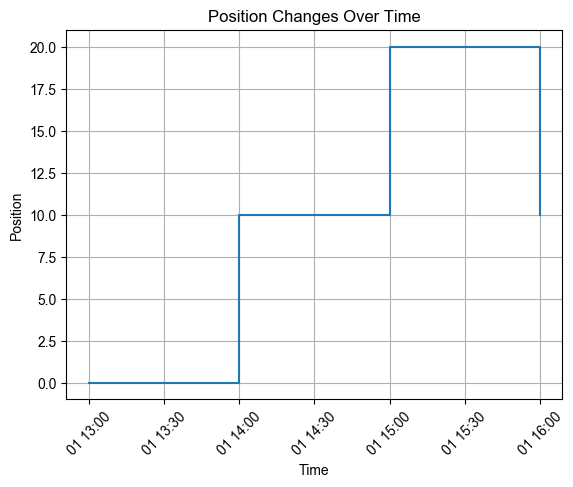

In [ ]:
import matplotlib.pyplot as plt

# 示例数据
timestamps = ["2020-06-01 13:00:00", "2020-06-01 14:00:00", "2020-06-01 15:00:00", "2020-06-01 16:00:00"]
positions = [0, 10, 20, 10]

# 将时间字符串转换为 datetime 对象
timestamps = [pd.to_datetime(ts) for ts in timestamps]

# 绘制阶跃函数图
plt.step(timestamps, positions, where='post')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position Changes Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# 生成颜色 数据去掉时间戳

In [ ]:
import json
import random
# 定义种子

def generate_color_map(flat_list):
    # 提取所有机构的名称并去重
    organizations = set(item['name'] for item in flat_list)
    num_organizations = len(organizations)
    # 设置HSL颜色空间中的饱和度和亮度
    saturation = 40  # 降低饱和度
    lightness = 70  # 提高亮度
    # 计算每个机构之间色相的步长
    hue_step = 360 / num_organizations
    # 生成所有颜色的HSL值列表
    hsl_colors = [(i * hue_step, saturation, lightness) for i in range(num_organizations)]
    # 随机化颜色顺序以确保颜色的随机性
    seed = 42
    random.seed(seed)
    random.shuffle(hsl_colors)
    
    color_map = {}
    for i, org in enumerate(organizations):
        # 选择颜色列表中的下一个颜色
        h, s, l = hsl_colors[i]
        # 将HSL颜色转换为RGB格式
        rgb_color = hsl_to_rgb(h, s, l)
        # 将RGB格式的颜色存储在颜色映射中
        color_map[org] = rgb_color
        
    return color_map

def hsl_to_rgb(h, s, l):
    h /= 360
    s /= 100
    l /= 100
    if s == 0:
        r = g = b = l
    else:
        def hue_to_rgb(p, q, t):
            if t < 0:
                t += 1
            if t > 1:
                t -= 1
            if t < 1/6:
                return p + (q - p) * 6 * t
            if t < 1/2:
                return q
            if t < 2/3:
                return p + (q - p) * (2/3 - t) * 6
            return p

        if l < 0.5:
            q = l * (1 + s)
        else:
            q = l + s - l * s
        p = 2 * l - q
        r = hue_to_rgb(p, q, h + 1/3)
        g = hue_to_rgb(p, q, h)
        b = hue_to_rgb(p, q, h - 1/3)
    
    return int(r * 255), int(g * 255), int(b * 255)

def generate_data_chain_json(flat_list, output_file):
    # 构建 bundles
    bundles = [{"links": []}]
    # 构建 nodes
    nodes = []

    # 将 flat_list 中的每个项目添加到 nodes 列表中，并同时构建 links 列表
    for i, item in enumerate(flat_list):
        # 构建节点
        nodes.append({
            'name': item['name'],
            'time_dl': item['time_dl'],
            'volume': item['volume'],
            'price': item['price'],
            'xy_coordinates': item['xy_coordinates'],
            'color': item['color']  # 添加颜色项
        })

    # 构建 tangleLayout
    tangleLayout = {'bundles': bundles, 'nodes': nodes}

    # 将 tangleLayout 写入 JSON 文件
    with open(output_file, "w") as json_file:
        json.dump(tangleLayout, json_file, indent=4)

def convert_timestamp_to_string(all_paths_with_xy):
    """
    将数据中的时间戳字段转换为字符串格式，并返回转换后的副本
    
    参数：
        - all_paths_with_xy: 包含路径数据的列表
    
    返回：
        - 转换后的副本列表
    """
    converted_paths = []
    for path in all_paths_with_xy:
        converted_path = []
        for item in path:
            converted_item = item.copy()
            timestamp = item['time_dl']
            # 将Timestamp转换为字符串
            time_str = timestamp.strftime('%Y-%m-%d %H:%M:%S')
            # 更新字典中的值
            converted_item['time_dl'] = time_str
            converted_path.append(converted_item)
        converted_paths.append(converted_path)
    return converted_paths

def add_color_to_items(flat_list, color_map):
    """
    给 flat_list 中的每个项添加颜色项。

    参数：
    - flat_list: 包含项的列表。
    - color_map: 包含机构颜色映射的字典。

    返回：
    添加颜色项后的项列表。
    """
    flat_list_with_color = []
    for item in flat_list:
        # 从 color_map 中获取相应机构的颜色
        color = color_map.get(item['name'], (255, 255, 255))  # 默认为白色
        # 将颜色添加到每个项中
        item_with_color = {
            'name': item['name'],
            'time_dl': item['time_dl'],
            'volume': item['volume'],
            'price': item['price'],
            'xy_coordinates': item['xy_coordinates'],
            'color': color  # 添加颜色项
        }
        flat_list_with_color.append(item_with_color)
    return flat_list_with_color

# 使用示例
converted_paths = convert_timestamp_to_string(all_paths_with_xy)
flat_list = [item for sublist in converted_paths for item in sublist]
color_map = generate_color_map(flat_list)
flat_list_with_color = add_color_to_items(flat_list, color_map)
generate_data_chain_json(flat_list_with_color, "data_chain.json")


# 另一种设计

In [ ]:
  # var volumes = d3.set(graph.nodes.map(function (d) {
  #   d.firstVolume = d.chapters.map(function (c) { return c[0]; }).sort()[0];
  #   return d.firstVolume;
  # })).values().sort();

  # // Make sure small nodes are drawn on top of larger nodes
  # graph.nodes.sort(function (a, b) { return b.chapters.length - a.chapters.length; });

  # nodeRadius.domain([graph.nodes[graph.nodes.length-1].chapters.length, graph.nodes[0].chapters.length]);

  # linkWidth.domain(d3.extent(graph.links, function (d) { return d.chapters.length; }));

  # xGravity.domain(volumes).range(d3.range(0,volumes.length).map(function (d) { return width / (2 * volumes.length) + d * width / volumes.length; }));
  # xMin.domain(volumes).range(d3.range(0,volumes.length).map(function (d) { return d * width / volumes.length; }));
  # xMax.domain(volumes).range(d3.range(0,volumes.length).map(function (d) { return (d + 1) * width / volumes.length; }));

  # graph.nodes.forEach(function (d) { d.x = xGravity(d.firstVolume) + width * (Math.random() - 0.5); d.y = height * (Math.random() - 0.5); });

  # var bars = svg.append('g')
  #   .attr('class', 'bars')
  #   .selectAll('line')
  #   .data(volumes.slice(0, volumes.length - 1))
  #   .enter().append('line')
  #   .attr('x1', function (d) { return xMax(d); })
  #   .attr('y1', 0)
  #   .attr('x2', function (d) { return xMax(d); })
  #   .attr('y2', height);

# 标记做市交易者

In [ ]:
from collections import Counter

def identify_market_makers(transactions, time_window, max_price_difference, matching_ratio_threshold, trader_count_threshold):
    market_makers = set()

    trader_transactions = {}  # 存储每个交易者的所有交易

    # 根据交易者分组
    for index, transaction in transactions.iterrows():
        buyer = transaction['buyer']
        seller = transaction['seller']
        if buyer not in trader_transactions:
            trader_transactions[buyer] = []
        trader_transactions[buyer].append(transaction)
        if seller not in trader_transactions:
            trader_transactions[seller] = []
        trader_transactions[seller].append(transaction)

    # 统计每个交易者的交易次数
    trader_counts = Counter(transactions['buyer'])
    trader_counts.update(transactions['seller'])

    # 计算交易笔数排名的阈值
    trader_count_threshold = int(len(trader_counts) * 0.05)

    # 遍历每个交易者的所有交易
    for trader, transactions in trader_transactions.items():
        matching_count = 0
        total_count = len(transactions)
        large_price_difference = False  # 是否存在价格差异很大的交易

        # 检查交易者的交易次数是否超过阈值
        if trader_counts[trader] > trader_count_threshold:
            # 检查每笔交易是否有匹配的交易，并且价格差小于等于0.1
            for transaction1 in transactions:
                for transaction2 in transactions:
                    if abs((transaction2['date'] - transaction1['date']).days) <= time_window:
                        price_difference = abs(transaction1['price'] - transaction2['price'])
                        if price_difference > max_price_difference:
                            large_price_difference = True
                        elif transaction1['volume'] == transaction2['volume']:
                            matching_count += 1
                            break  # 匹配到一笔交易就跳出内层循环

            # 计算匹配比例
            matching_ratio = matching_count / total_count

            # 如果价格差异很大，或者匹配比例不满足条件，则排除该交易者
            if not large_price_difference and matching_ratio >= matching_ratio_threshold:
                market_makers.add(trader)

    return market_makers

# 调用函数识别做市交易者
market_makers = identify_market_makers(sorted_data, time_window=1, max_price_difference=0.1, matching_ratio_threshold=0.9, trader_count_threshold=5)
print("做市交易者:", market_makers)


做市交易者: {'麦高证券有限安智', '粤开证券股份周荃', '吉林九台农村刘刊', '粤开证券股份葛天翔', '五矿证券有限刘颖', '潍坊银行股份王梓涵', '中信证券股份王焕智', '川财证券有限李丹', '交通银行股份何嘉隆', '华泰证券股份李雨婷', '国金证券股份严佳', '广东顺德农村夏扬', '东海证券股份温妍超', '麦高证券有限赵劼勋', '鄂尔多斯银行郭宁', '华源证券股份瞿鑫'}


# 计算机构头寸

In [ ]:
def calculate_position_and_trades(name, merged_df):
    transactions = merged_df[(merged_df['seller'] == name) | (merged_df['buyer'] == name)]
    buy_transactions = transactions[transactions['buyer'] == name].sort_values(by='date').reset_index(drop=True)
    sell_transactions = transactions[transactions['seller'] == name].sort_values(by='date').reset_index(drop=True)

    # 记录交易次数的计数器
    trade_count = 0

    def dp(buy_idx, sell_idx, remaining_buy, remaining_sell):
        nonlocal trade_count  # 使用nonlocal关键字引用外部的trade_count变量
        if buy_idx >= len(buy_transactions) or sell_idx >= len(sell_transactions):
            return remaining_buy - remaining_sell

        # 计算当前买入和卖出交易的抵消量
        offset = min(buy_transactions.loc[buy_idx]['volume'], sell_transactions.loc[sell_idx]['volume'])

        # 更新剩余买入和卖出交易量
        remaining_buy -= offset
        remaining_sell -= offset

        # 更新买入和卖出交易的索引
        next_buy_idx = buy_idx + (buy_transactions.loc[buy_idx]['volume'] == offset)
        next_sell_idx = sell_idx + (sell_transactions.loc[sell_idx]['volume'] == offset)

        # 统计交易次数
        trade_count += 1

        # 继续递归
        return dp(next_buy_idx, next_sell_idx, remaining_buy, remaining_sell)

    # 调用动态规划函数
    position = dp(0, 0, buy_transactions['volume'].sum(), sell_transactions['volume'].sum())

    # 返回头寸和交易次数
    return position, trade_count


In [ ]:
buyer_seller_names = set(merged_df['buyer']).union(set(merged_df['seller']))
trader_transactions = list(buyer_seller_names)
# 计算每一个机构的价格列表的统计信息，作为节点的属性添加到图中
for name in trader_transactions:
    position, trade_count = calculate_position_and_trades(name, merged_df)
    print(f"{name}:, Position: {position}, trade_count: {trade_count}")


山西证券股份赖颂怡:, Position: 0, trade_count: 1
粤开证券股份周荃:, Position: 0, trade_count: 1
招商银行股份林颖颖:, Position: -10, trade_count: 0
粤开证券股份葛天翔:, Position: 0, trade_count: 1
中国人民人寿宋帅:, Position: 10, trade_count: 0
交银人寿保险鲜佳慧:, Position: 25, trade_count: 0
国金证券股份严佳:, Position: 10, trade_count: 0
麦高证券有限赵劼勋:, Position: 10, trade_count: 0
中国光大银行张璇:, Position: -10, trade_count: 0
川财证券有限赖颂怡:, Position: 31, trade_count: 1
中原银行股份赵卓斌:, Position: -10, trade_count: 0
第一创业证券刘俊麒:, Position: -5, trade_count: 3
厦门银行股份赵颖:, Position: 0, trade_count: 1
华创证券有限王莹:, Position: 0, trade_count: 2
吉林九台农村刘刊:, Position: 0, trade_count: 1
五矿证券有限刘颖:, Position: -10, trade_count: 0
民生证券股份杨兴泉:, Position: -5, trade_count: 0
兴业银行股份陈颖1:, Position: -10, trade_count: 0
东海证券股份郭宇涵:, Position: 0, trade_count: 2
东海证券股份温妍超:, Position: -10, trade_count: 1
第一创业证券姜丁菱:, Position: -5, trade_count: 0
广东南海农村曹兆全:, Position: -4, trade_count: 1
川财证券有限高欣:, Position: -11, trade_count: 0
中国太平洋人孟祥钧:, Position: 30, trade_count: 0
中信银行股份张勇:, Position: -20,

华夏人寿保险李腾:, Position: 9, trade_count: 0
长生人寿保险谭嘉圣:, Position: 30, trade_count: 0
中国人民财产丁仪:, Position: 40, trade_count: 0
新华资产管理郝黎红:, Position: 39, trade_count: 0
上海浦东发展宋震:, Position: -6, trade_count: 0
中国太平洋人陈阳:, Position: 25, trade_count: 0
川财证券有限马白帆:, Position: 0, trade_count: 1
鄂尔多斯银行郭宁:, Position: 0, trade_count: 3
麦高证券有限安智:, Position: -10, trade_count: 0
中信证券股份丁亮邦:, Position: -10, trade_count: 0
五矿证券有限钟莉雯:, Position: -7, trade_count: 0
新华资产管理张颖涵:, Position: 6, trade_count: 0
华宝证券股份林斯妤:, Position: 20, trade_count: 5
中信证券股份王焕智:, Position: 0, trade_count: 1
中英人寿保险马维慧:, Position: 5, trade_count: 0
兴业银行股份陈颖:, Position: -51, trade_count: 0
兴业银行股份程海卓:, Position: -5, trade_count: 0
广东顺德农村夏扬:, Position: 10, trade_count: 0
财信证券股份代梦玉:, Position: 10, trade_count: 0
华创证券有限隋周奕:, Position: 5, trade_count: 0
华创证券有限马延威:, Position: 0, trade_count: 6
潍坊银行股份王梓涵:, Position: 0, trade_count: 1
中国国际金融周佳:, Position: 0, trade_count: 1
华林证券股份韩婷婷:, Position: 5, trade_count: 0
华源证券股份瞿鑫:, Position: 10, trade_co

# 计算头寸相消的交易量：

In [ ]:
def calculate_offset_trades(name, merged_df):
    # 在函数内部计算全局的平均头寸
    total_volume = merged_df['volume'].sum()
    total_count = len(merged_df)
    global_average_position = total_volume / total_count

    transactions = merged_df[(merged_df['seller'] == name) | (merged_df['buyer'] == name)]
    buy_transactions = transactions[transactions['buyer'] == name].sort_values(by='date').reset_index(drop=True)
    sell_transactions = transactions[transactions['seller'] == name].sort_values(by='date').reset_index(drop=True)

    offset_volume = 0
    offset_count = 0  # 新增的相消计数器

    if len(buy_transactions) == 0 or len(sell_transactions) == 0:
        # 如果没有足够的交易数据进行对冲，将单笔头寸设置为全局的平均头寸，将对冲次数设置为1
        if len(buy_transactions) == 0:
            offset_volume = sell_transactions['volume'].mean() if not sell_transactions.empty else 0
        elif len(sell_transactions) == 0:
            offset_volume = buy_transactions['volume'].mean() if not buy_transactions.empty else 0
        offset_count = 1
        return offset_volume, offset_count  

    i = 0
    j = 0
    while i < len(buy_transactions) and j < len(sell_transactions):
        if abs((buy_transactions['date'][i] - sell_transactions['date'][j]).days) > 4:
            if buy_transactions['date'][i] > sell_transactions['date'][j]:
                j += 1
            else:
                i += 1
        elif buy_transactions['volume'][i] == sell_transactions['volume'][j]:
            offset_volume += buy_transactions['volume'][i]
            sell_transactions = sell_transactions.drop(j).reset_index(drop=True)
            offset_count += 1  # 相消发生时增加计数
            i += 1
        elif buy_transactions['volume'][i] < sell_transactions['volume'][j]:
            sell_transactions.at[j, 'volume'] -= buy_transactions['volume'][i]
            offset_volume += buy_transactions['volume'][i]
            offset_count += 1  # 相消发生时增加计数
            i += 1
        else:
            buy_transactions.at[i, 'volume'] -= sell_transactions['volume'][j]
            offset_volume += sell_transactions['volume'][j]
            offset_count += 1  # 相消发生时增加计数
            j += 1
    # 如果对冲交易额为零，将单笔头寸设置为该交易员买入或卖出volume的平均值
    if offset_volume < 0.01:
        mean_volume = merged_df[(merged_df['seller'] == name) | (merged_df['buyer'] == name)]['volume'].mean()
        offset_volume = mean_volume if not np.isnan(mean_volume) else 0
        offset_count = 1  # 避免除零错误
    return offset_volume, offset_count  # 返回相消总量和相消次数


In [ ]:
buyer_seller_names = set(merged_df['buyer']).union(set(merged_df['seller']))
trader_transactions = list(buyer_seller_names)


# 计算每一个机构的价格列表的统计信息，作为节点的属性添加到图中
for name in trader_transactions:
    offset_volume, offset_count = calculate_offset_trades(name, merged_df)
    print(f"{name}: average_position: {offset_volume/offset_count}")

山西证券股份赖颂怡: average_position: 10.0
粤开证券股份周荃: average_position: 10.0
招商银行股份林颖颖: average_position: 10.0
粤开证券股份葛天翔: average_position: 10.0
中国人民人寿宋帅: average_position: 10.0
交银人寿保险鲜佳慧: average_position: 12.5
国金证券股份严佳: average_position: 10.0
麦高证券有限赵劼勋: average_position: 10.0
中国光大银行张璇: average_position: 10.0
川财证券有限赖颂怡: average_position: 20.0
中原银行股份赵卓斌: average_position: 10.0
第一创业证券刘俊麒: average_position: 8.333333333333334
厦门银行股份赵颖: average_position: 20.0
华创证券有限王莹: average_position: 10.0
吉林九台农村刘刊: average_position: 10.0
五矿证券有限刘颖: average_position: 10.0
民生证券股份杨兴泉: average_position: 5.0
兴业银行股份陈颖1: average_position: 10.0
东海证券股份郭宇涵: average_position: 10.0
东海证券股份温妍超: average_position: 10.0
第一创业证券姜丁菱: average_position: 5.0
广东南海农村曹兆全: average_position: 6.0
川财证券有限高欣: average_position: 5.5
中国太平洋人孟祥钧: average_position: 15.0
中信银行股份张勇: average_position: 20.0
申港证券股份刘俊骥: average_position: 5.0
川财证券有限李丹: average_position: 20.0
华夏人寿保险李腾: average_position: 9.0
长生人寿保险谭嘉圣: average_position: 30.0
中国人民财产丁仪: average_p

# 计算头寸相消的交易的利润和利润率：

In [ ]:
def calculate_offset_profit(name, merged_df):
    transactions = merged_df[(merged_df['seller'] == name) | (merged_df['buyer'] == name)]
    buy_transactions = transactions[transactions['buyer'] == name].sort_values(by='date').reset_index(drop=True)
    sell_transactions = transactions[transactions['seller'] == name].sort_values(by='date').reset_index(drop=True)

    offset_profit = 0
    i = 0
    j = 0
    while i < len(buy_transactions) and j < len(sell_transactions):
        if abs((buy_transactions['date'][i] - sell_transactions['date'][j]).days) > 4:
            if buy_transactions['date'][i] > sell_transactions['date'][j]:
                j += 1
            else:
                i += 1
        elif buy_transactions['volume'][i] == sell_transactions['volume'][j]:
            offset_profit += (sell_transactions['price'][j] - buy_transactions['price'][i]) * buy_transactions['volume'][i]
            # print(sell_transactions['date'][j], sell_transactions['price'][j] - buy_transactions['price'][i])
            sell_transactions = sell_transactions.drop(j).reset_index(drop=True)
            i += 1
        elif buy_transactions['volume'][i] < sell_transactions['volume'][j]:
            offset_profit += (sell_transactions['price'][j] - buy_transactions['price'][i]) * buy_transactions['volume'][i]
            # print(sell_transactions['date'][j], sell_transactions['price'][j] - buy_transactions['price'][i])
            sell_transactions.at[j, 'volume'] -= buy_transactions['volume'][i]
            i += 1
        else:
            offset_profit += (sell_transactions['price'][j] - buy_transactions['price'][i]) * sell_transactions['volume'][j]
            # print(sell_transactions['date'][j], sell_transactions['price'][j] - buy_transactions['price'][i])
            buy_transactions.at[i, 'volume'] -= sell_transactions['volume'][j]
            j += 1

    return offset_profit

In [ ]:
buyer_seller_names = set(merged_df['buyer']).union(set(merged_df['seller']))
trader_transactions = list(buyer_seller_names)

# 计算每一个机构的价格列表的统计信息，作为节点的属性添加到图中
for name in trader_transactions:
    profit = calculate_offset_profit(name, merged_df)
    print(f"{name}: profit: {profit}")


山西证券股份赖颂怡: profit: 0.0
粤开证券股份周荃: profit: 0.10000000000005116
招商银行股份林颖颖: profit: 0
粤开证券股份葛天翔: profit: 0.1999999999999602
中国人民人寿宋帅: profit: 0
交银人寿保险鲜佳慧: profit: 0
国金证券股份严佳: profit: 0
麦高证券有限赵劼勋: profit: 0
中国光大银行张璇: profit: 0
川财证券有限赖颂怡: profit: 1.9999999999998863
中原银行股份赵卓斌: profit: 0
第一创业证券刘俊麒: profit: 0.0
厦门银行股份赵颖: profit: 0.0
华创证券有限王莹: profit: 0.0
吉林九台农村刘刊: profit: 0.10000000000005116
五矿证券有限刘颖: profit: 0
民生证券股份杨兴泉: profit: 0
兴业银行股份陈颖1: profit: 0
东海证券股份郭宇涵: profit: 3.6999999999999034
东海证券股份温妍超: profit: 0.4999999999999716
第一创业证券姜丁菱: profit: 0
广东南海农村曹兆全: profit: 0.8400000000000034
川财证券有限高欣: profit: 0
中国太平洋人孟祥钧: profit: 0
中信银行股份张勇: profit: 0
申港证券股份刘俊骥: profit: 0
川财证券有限李丹: profit: -1.8000000000000682
华夏人寿保险李腾: profit: 0
长生人寿保险谭嘉圣: profit: 0
中国人民财产丁仪: profit: 0
新华资产管理郝黎红: profit: 0
上海浦东发展宋震: profit: 0
中国太平洋人陈阳: profit: 0
川财证券有限马白帆: profit: 0.15000000000000568
鄂尔多斯银行郭宁: profit: 0.0
麦高证券有限安智: profit: 0
中信证券股份丁亮邦: profit: 0
五矿证券有限钟莉雯: profit: 0
新华资产管理张颖涵: profit: 0
华宝证券股份林斯妤: profit: 0.6500000000

# 计算头寸相消的交易的亏损

# 计算出交易量 卖出和买入中的更大值

In [ ]:
def calculate_total_volume(name, merged_df):
    buy_transactions = merged_df[(merged_df['buyer'] == name)]
    sell_transactions = merged_df[(merged_df['seller'] == name)]

    buy_volume = buy_transactions['volume'].sum()
    sell_volume = sell_transactions['volume'].sum()

    return max(buy_volume, sell_volume)

In [ ]:
buyer_seller_names = set(merged_df['buyer']).union(set(merged_df['seller']))
trader_transactions = list(buyer_seller_names)


# 计算每一个机构的价格列表的统计信息，作为节点的属性添加到图中
for name in trader_transactions:
    total_volume = calculate_total_volume(name, merged_df)
    print(f"{name}:, total_volume: {total_volume}")


山西证券股份赖颂怡:, total_volume: 10
粤开证券股份周荃:, total_volume: 10
招商银行股份林颖颖:, total_volume: 10
粤开证券股份葛天翔:, total_volume: 10
中国人民人寿宋帅:, total_volume: 10
交银人寿保险鲜佳慧:, total_volume: 25
国金证券股份严佳:, total_volume: 10
麦高证券有限赵劼勋:, total_volume: 10
中国光大银行张璇:, total_volume: 10
川财证券有限赖颂怡:, total_volume: 51
中原银行股份赵卓斌:, total_volume: 10
第一创业证券刘俊麒:, total_volume: 30
厦门银行股份赵颖:, total_volume: 20
华创证券有限王莹:, total_volume: 20
吉林九台农村刘刊:, total_volume: 10
五矿证券有限刘颖:, total_volume: 10
民生证券股份杨兴泉:, total_volume: 5
兴业银行股份陈颖1:, total_volume: 10
东海证券股份郭宇涵:, total_volume: 20
东海证券股份温妍超:, total_volume: 20
第一创业证券姜丁菱:, total_volume: 5
广东南海农村曹兆全:, total_volume: 10
川财证券有限高欣:, total_volume: 11
中国太平洋人孟祥钧:, total_volume: 30
中信银行股份张勇:, total_volume: 20
申港证券股份刘俊骥:, total_volume: 5
川财证券有限李丹:, total_volume: 60
华夏人寿保险李腾:, total_volume: 9
长生人寿保险谭嘉圣:, total_volume: 30
中国人民财产丁仪:, total_volume: 40
新华资产管理郝黎红:, total_volume: 39
上海浦东发展宋震:, total_volume: 6
中国太平洋人陈阳:, total_volume: 25
川财证券有限马白帆:, total_volume: 5
鄂尔多斯银行郭宁:, total_volume: 30
麦高证券有限安

# 计算盈利百分比

In [ ]:
import numpy as np

# 字典用于保存每个机构的利润、平均头寸和盈利百分比
trader_stats = {}

for name in trader_transactions:
    offset_volume, offset_count = calculate_offset_trades(name, merged_df)
    offset_profit = calculate_offset_profit(name, merged_df)
    
    # 计算平均头寸
    mean_volume = merged_df[(merged_df['seller'] == name) | (merged_df['buyer'] == name)]['volume'].mean()
    average_position = mean_volume if not np.isnan(mean_volume) else 0
    
    # 计算盈利百分比
    profit_percentage = (offset_profit / average_position) * 100 if average_position != 0 else 0
    
    # 将结果保存到字典中
    trader_stats[name] = {'offset_profit': offset_profit, 'average_position': average_position, 'profit_percentage': profit_percentage}

# 打印结果
for name, stats in trader_stats.items():
    print(f"Trader: {name}")
    print(f"Offset Profit: {stats['offset_profit']}")
    print(f"Average Position: {stats['average_position']}")
    print(f"Profit Percentage: {stats['profit_percentage']}")
    print()


Trader: 山西证券股份赖颂怡
Offset Profit: 0.0
Average Position: 10.0
Profit Percentage: 0.0

Trader: 粤开证券股份周荃
Offset Profit: 0.10000000000005116
Average Position: 10.0
Profit Percentage: 1.0000000000005116

Trader: 招商银行股份林颖颖
Offset Profit: 0
Average Position: 10.0
Profit Percentage: 0.0

Trader: 粤开证券股份葛天翔
Offset Profit: 0.1999999999999602
Average Position: 10.0
Profit Percentage: 1.999999999999602

Trader: 中国人民人寿宋帅
Offset Profit: 0
Average Position: 10.0
Profit Percentage: 0.0

Trader: 交银人寿保险鲜佳慧
Offset Profit: 0
Average Position: 12.5
Profit Percentage: 0.0

Trader: 国金证券股份严佳
Offset Profit: 0
Average Position: 10.0
Profit Percentage: 0.0

Trader: 麦高证券有限赵劼勋
Offset Profit: 0
Average Position: 10.0
Profit Percentage: 0.0

Trader: 中国光大银行张璇
Offset Profit: 0
Average Position: 10.0
Profit Percentage: 0.0

Trader: 川财证券有限赖颂怡
Offset Profit: 1.9999999999998863
Average Position: 23.666666666666668
Profit Percentage: 8.450704225351632

Trader: 中原银行股份赵卓斌
Offset Profit: 0
Average Position: 10.0
Profit Percenta

In [ ]:
import pandas as pd
import numpy as np

# 这是你的数据
data = merged_df

df = pd.DataFrame(data)

# 获取买家和卖家的价格列表
buyer_prices = df.groupby('buyer')['price'].apply(list).to_dict()
seller_prices = df.groupby('seller')['price'].apply(list).to_dict()

# 合并买家和卖家的价格列表
from collections import defaultdict
institution_prices = defaultdict(list)

for d in (buyer_prices, seller_prices):
    for key, value in d.items():
        institution_prices[key].extend(value)

# 输出结果
# print(dict(institution_prices))

# 定义计算方差和最大值最小值差的函数
def calculate_statistics(price_list):

    var = np.var(price_list) if len(price_list) > 1 else 0
    range_ = np.max(price_list) - np.min(price_list)

    return {
        "Variance": var,
        "Range": range_
    }

# 对每个人的价格列表执行统计计算
for name, price_list in dict(institution_prices).items():
    stats = calculate_statistics(price_list)
    print(f"Name: {name}, Statistics: {stats}")


Name: 东方证券股份陈玉婷, Statistics: {'Variance': 2.0194839173657902e-28, 'Range': 0.0}
Name: 东海证券股份温妍超, Statistics: {'Variance': 3.600555555555553, 'Range': 4.049999999999997}
Name: 东海证券股份郭宇涵, Statistics: {'Variance': 0.15934999999999905, 'Range': 1.0999999999999943}
Name: 中信证券股份刘鸿达, Statistics: {'Variance': 0, 'Range': 0.0}
Name: 中信证券股份王焕智, Statistics: {'Variance': 0.3249000000000003, 'Range': 1.1400000000000006}
Name: 中原银行股份杨坤鹏, Statistics: {'Variance': 0, 'Range': 0.0}
Name: 中国人民人寿宋帅, Statistics: {'Variance': 0, 'Range': 0.0}
Name: 中国人民财产丁仪, Statistics: {'Variance': 2.0194839173657902e-28, 'Range': 0.0}
Name: 中国国际金融周佳, Statistics: {'Variance': 0.000624999999999929, 'Range': 0.04999999999999716}
Name: 中国国际金融张婉靖, Statistics: {'Variance': 0.0, 'Range': 0.0}
Name: 中国太平洋人孟祥钧, Statistics: {'Variance': 0.00490000000000004, 'Range': 0.14000000000000057}
Name: 中国太平洋人陈添缘, Statistics: {'Variance': 0, 'Range': 0.0}
Name: 中国太平洋人陈阳, Statistics: {'Variance': 0.019599999999998167, 'Range': 0.2799999999999

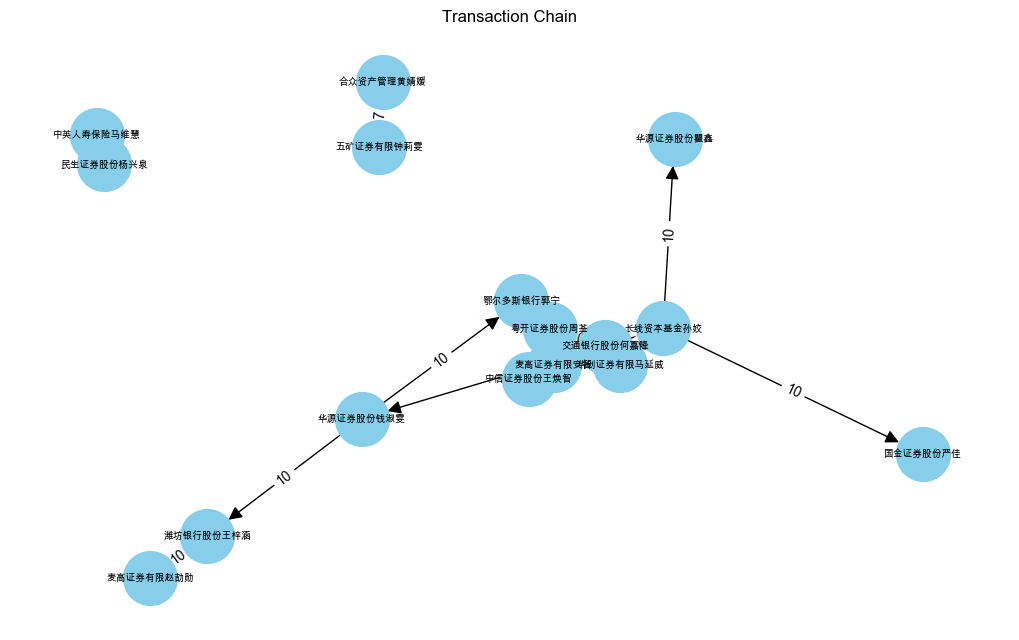

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = merged_df
# 将日期转换为 datetime 对象
df['date'] = pd.to_datetime(df['date'])

# 根据日期和其他关键列对数据进行排序
df = df.sort_values(by=['date', 'buyer', 'seller'])

# 定义一个函数来执行合并逻辑
def merge_transactions(df, window=3):
    merged_transactions = []
    current_transaction = None
    
    for _, row in df.iterrows():
        if current_transaction is None:
            current_transaction = row
            continue
        
        if (row['date'] - current_transaction['date']).days <= window:
            if row['buyer'] == current_transaction['buyer'] and row['seller'] == current_transaction['seller'] and row['price'] == current_transaction['price']:
                current_transaction['volume'] += row['volume']
            else:
                merged_transactions.append(current_transaction)
                current_transaction = row
        else:
            merged_transactions.append(current_transaction)
            current_transaction = row
            
    if current_transaction is not None:
        merged_transactions.append(current_transaction)
    
    return pd.DataFrame(merged_transactions)
# 执行合并逻辑
df = merge_transactions(df)[70:]

# 创建有向图
G = nx.DiGraph()

# 添加边到图中，并记录获利
for _, row in df.iterrows():
    G.add_edge(row['seller'], row['buyer'], volume=row['volume'], price=row['price'])

# 绘制有向图
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)  # 使用布局算法布置节点位置
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=7, font_weight="bold", arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'volume')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Transaction Chain")
plt.show()


In [ ]:
import json

# 将图导出为 JSON 格式
graph_data = nx.json_graph.node_link_data(G)

# 保存到文件
with open('graph.json', 'w') as f:
    json.dump(graph_data, f)


In [ ]:
def calculate_prices_list(df):
    # 获取买家和卖家的价格列表
    buyer_prices = df.groupby('buyer')['price'].apply(list).to_dict()
    seller_prices = df.groupby('seller')['price'].apply(list).to_dict()

    # 合并买家和卖家的价格列表
    from collections import defaultdict
    institution_prices = defaultdict(list)

    for d in (buyer_prices, seller_prices):
        for key, value in d.items():
            institution_prices[key].extend(value)

    return dict(institution_prices)
institution_prices = calculate_prices_list(merged_df)

In [ ]:
G = nx.DiGraph()
# 添加边到图中，并记录获利
for _, row in merged_df.iterrows():
    G.add_edge(row['seller'], row['buyer'], volume=row['volume'], price=row['price'])
for name, price_list in dict(institution_prices).items():
    stats = calculate_statistics(price_list)
    G.nodes[name]['statistics'] = stats
# 计算每个属性的最小值和范围
stats_keys = next(iter(G.nodes.values()))['statistics'].keys()  # 获取统计信息的键
min_values = {key: min(node['statistics'][key] for node in G.nodes.values()) for key in stats_keys}
max_values = {key: max(node['statistics'][key] for node in G.nodes.values()) for key in stats_keys}

# 初始化节点的归一化统计信息
for node in G.nodes.values():
    node['normalized_statistics'] = {}

# 归一化统计信息
for node in G.nodes.values():
    for key in stats_keys:
        value = node['statistics'][key]
        min_value = min_values[key]
        max_value = max_values[key]
        normalized_value = (value - min_value) / (max_value - min_value) if max_value != min_value else 0
        node['normalized_statistics'][key] = normalized_value


In [ ]:
min_values = {key: min(node['statistics'][key] for node in G.nodes.values()) for key in stats.keys()}